# Libraries

In [24]:
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(quanteda)))
suppressWarnings(suppressPackageStartupMessages(library(repr)))
options(repr.plot.width=15, repr.plot.height=12)


# Data

## Dataset

In [2]:
texts <- readRDS("data/joined_texts.rds")

texts <- texts %>% mutate(legislatura = as.integer(legislatura))

## Stopwords

In [3]:
db_additional_stopwords  <- suppressMessages(read_csv("data/it_stopwords_new_list.csv")) %>% 
                            pull(stopwords)

procedural_stopwords <- suppressMessages(read_csv("data/it_stopwords_procedural.csv")) %>% 
                        pull(it_stopwords_procedural)

## Dictionary

In [4]:
dictionaries <- readxl::read_xlsx("data/gruendl_terms_final.xlsx", sheet = 1)

people <- dictionaries %>% 
filter(!is.na(Decadri_Boussalis_Grundl_People)) %>% 
mutate(Decadri_Boussalis_Grundl_People = str_split(Decadri_Boussalis_Grundl_People, ', ')) %>% 
unnest(cols = c(Decadri_Boussalis_Grundl_People)) %>% 
distinct(Decadri_Boussalis_Grundl_People) %>% 
pull(Decadri_Boussalis_Grundl_People)

common_will <- dictionaries %>% 
filter(!is.na(Decadri_Boussalis_Grundl_Common_Will)) %>% 
mutate(Decadri_Boussalis_Grundl_Common_Will = str_split(Decadri_Boussalis_Grundl_Common_Will, ', ')) %>% 
unnest(cols = c(Decadri_Boussalis_Grundl_Common_Will)) %>% 
distinct(Decadri_Boussalis_Grundl_Common_Will) %>% 
pull(Decadri_Boussalis_Grundl_Common_Will)

elite <- dictionaries %>% 
filter(!is.na(Decadri_Boussalis_Grundl_Elite)) %>% 
mutate(Decadri_Boussalis_Grundl_Elite = str_split(Decadri_Boussalis_Grundl_Elite, ', ')) %>% 
unnest(cols = c(Decadri_Boussalis_Grundl_Elite)) %>% 
distinct(Decadri_Boussalis_Grundl_Elite) %>% 
pull(Decadri_Boussalis_Grundl_Elite)

dbg_dictionary <- dictionary(list(people = people, common_will = common_will, elite = elite))

# Pre-processing

Let's tokenize the corpus and remove mentions to "il popolo della libertà"

In [5]:
final_corpus <- corpus(texts, text_field = "textclean")

In [6]:
final_toks <- tokens(final_corpus, remove_punct = TRUE, remove_symbols = TRUE, remove_numbers = TRUE, remove_separators = TRUE)  %>% 
              tokens_remove(., pattern = stopwords("it"), padding = TRUE) %>% 
              tokens_remove(., pattern = db_additional_stopwords) %>% 
              tokens_remove(., pattern = procedural_stopwords) %>% 
              tokens_remove(., pattern = c("popolo dell* libert*", "popolo della libertà", "popolo della liberta"))

# Dictionary analysis

In [7]:
no_pdl <- tokens_lookup(x = final_toks, dictionary = dbg_dictionary) %>% 
dfm() %>% 
convert(., to = "data.frame") %>% 
mutate(gruppoP_recoded = docvars(final_toks)$gruppoP_recoded,
       legislature = docvars(final_toks)$legislature,
       year = docvars(final_toks)$year,
       gov_member = docvars(final_toks)$Gov_memb,
       external_support = docvars(final_toks)$External_sup,
       classic_left_right = docvars(final_toks)$left_right,
       ratio_left_right = docvars(final_toks)$ratio_leftright,
       logit_left_right = docvars(final_toks)$logit_left_right,
       classic_economic = docvars(final_toks)$classic_economic,
       ratio_economic = docvars(final_toks)$ratio_economic,
       logit_economic = docvars(final_toks)$logit_economic,
       classic_gal_tan = docvars(final_toks)$classic_gal_tan,
       ratio_gal_tan = docvars(final_toks)$ratio_gal_tan,
       logit_gal_tan = docvars(final_toks)$logit_gal_tan,
       classic_economic_gal_tan = docvars(final_toks)$classic_economic_gal_tan,
       ratio_economic_gal_tan = docvars(final_toks)$ratio_economic_gal_tan,
       logit_economic_gal_tan = docvars(final_toks)$logit_economic_gal_tan,
       perc_of_populist_toks = (people + common_will + elite) / ntoken(final_toks),
       standardized_perc_of_populist_toks = as.double(scale(perc_of_populist_toks)))

Load the results of the individual-level analysis

In [17]:
df <- read_csv("C:\\Users\\jacop\\Tesi\\individual_results.csv", show_col_types = FALSE)

This is the average percentage of populist without removing mentions of "Il popolo della libertà"

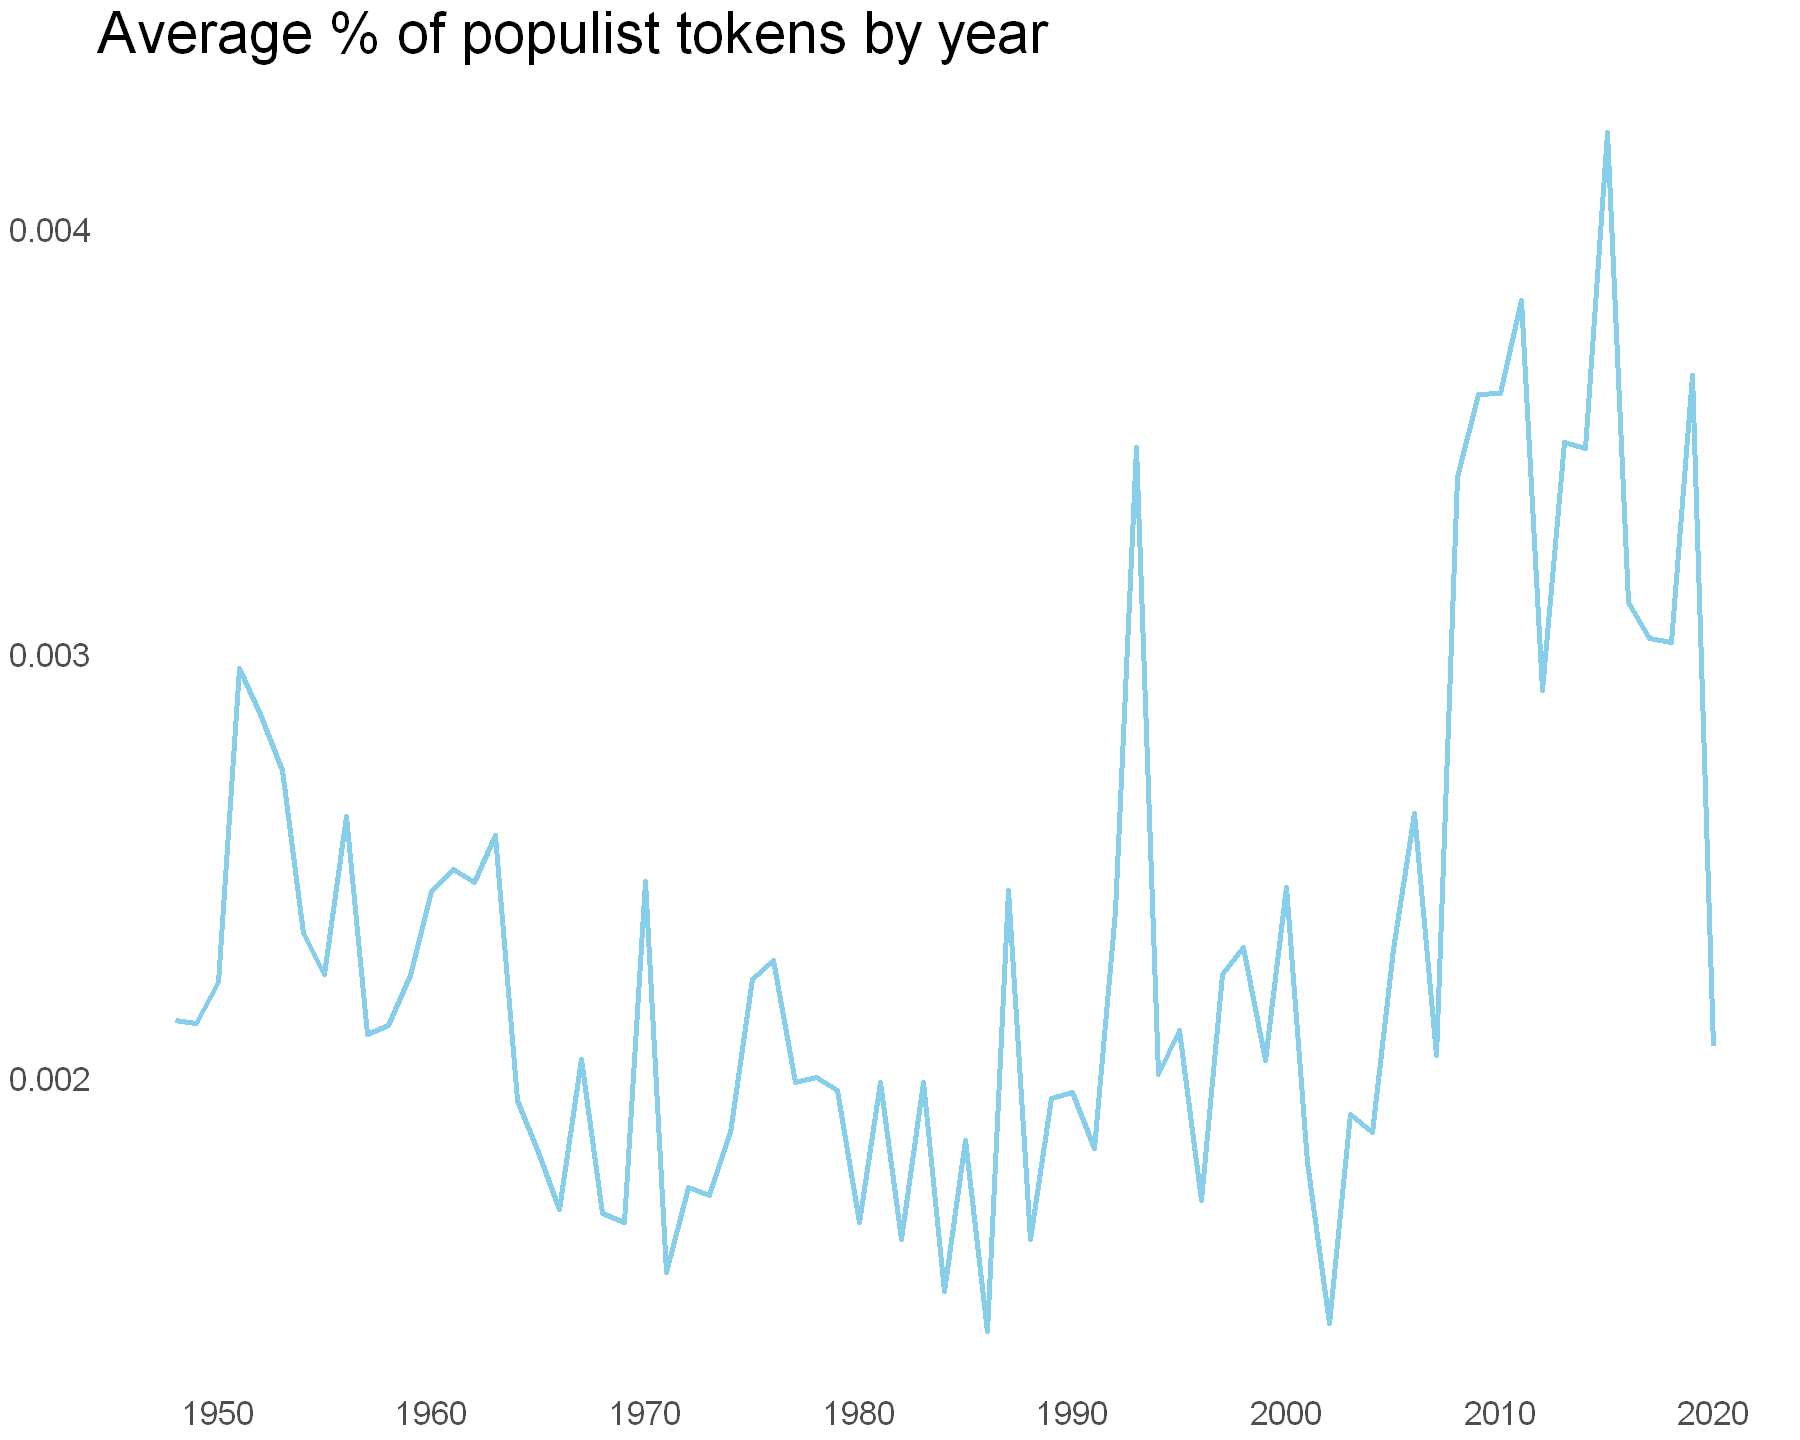

In [33]:
df %>% 
     group_by(year) %>% 
     summarise(avg_perc_of_populist_tokens = mean(perc_of_populist_toks, na.rm = TRUE)) %>% 
     ggplot(aes(x = year, y = avg_perc_of_populist_tokens)) +
     geom_line(colour = "sky blue", size = 1.5) +
     theme_classic() +
     scale_x_continuous(breaks = seq(from = 1950, to = 2020, by = 10)) +
     labs(title = "Average % of populist tokens by year") +
     theme(line = element_blank(),
           axis.title = element_blank(),
           plot.title = element_text(size = 35),
           axis.text = element_text(size = 20))

And this is the same metric after we've revemod mentions to "il popolo della libertà". The two visualizations are virtually identical. We can thus conclude that those mentions did not affect our dependent variable.

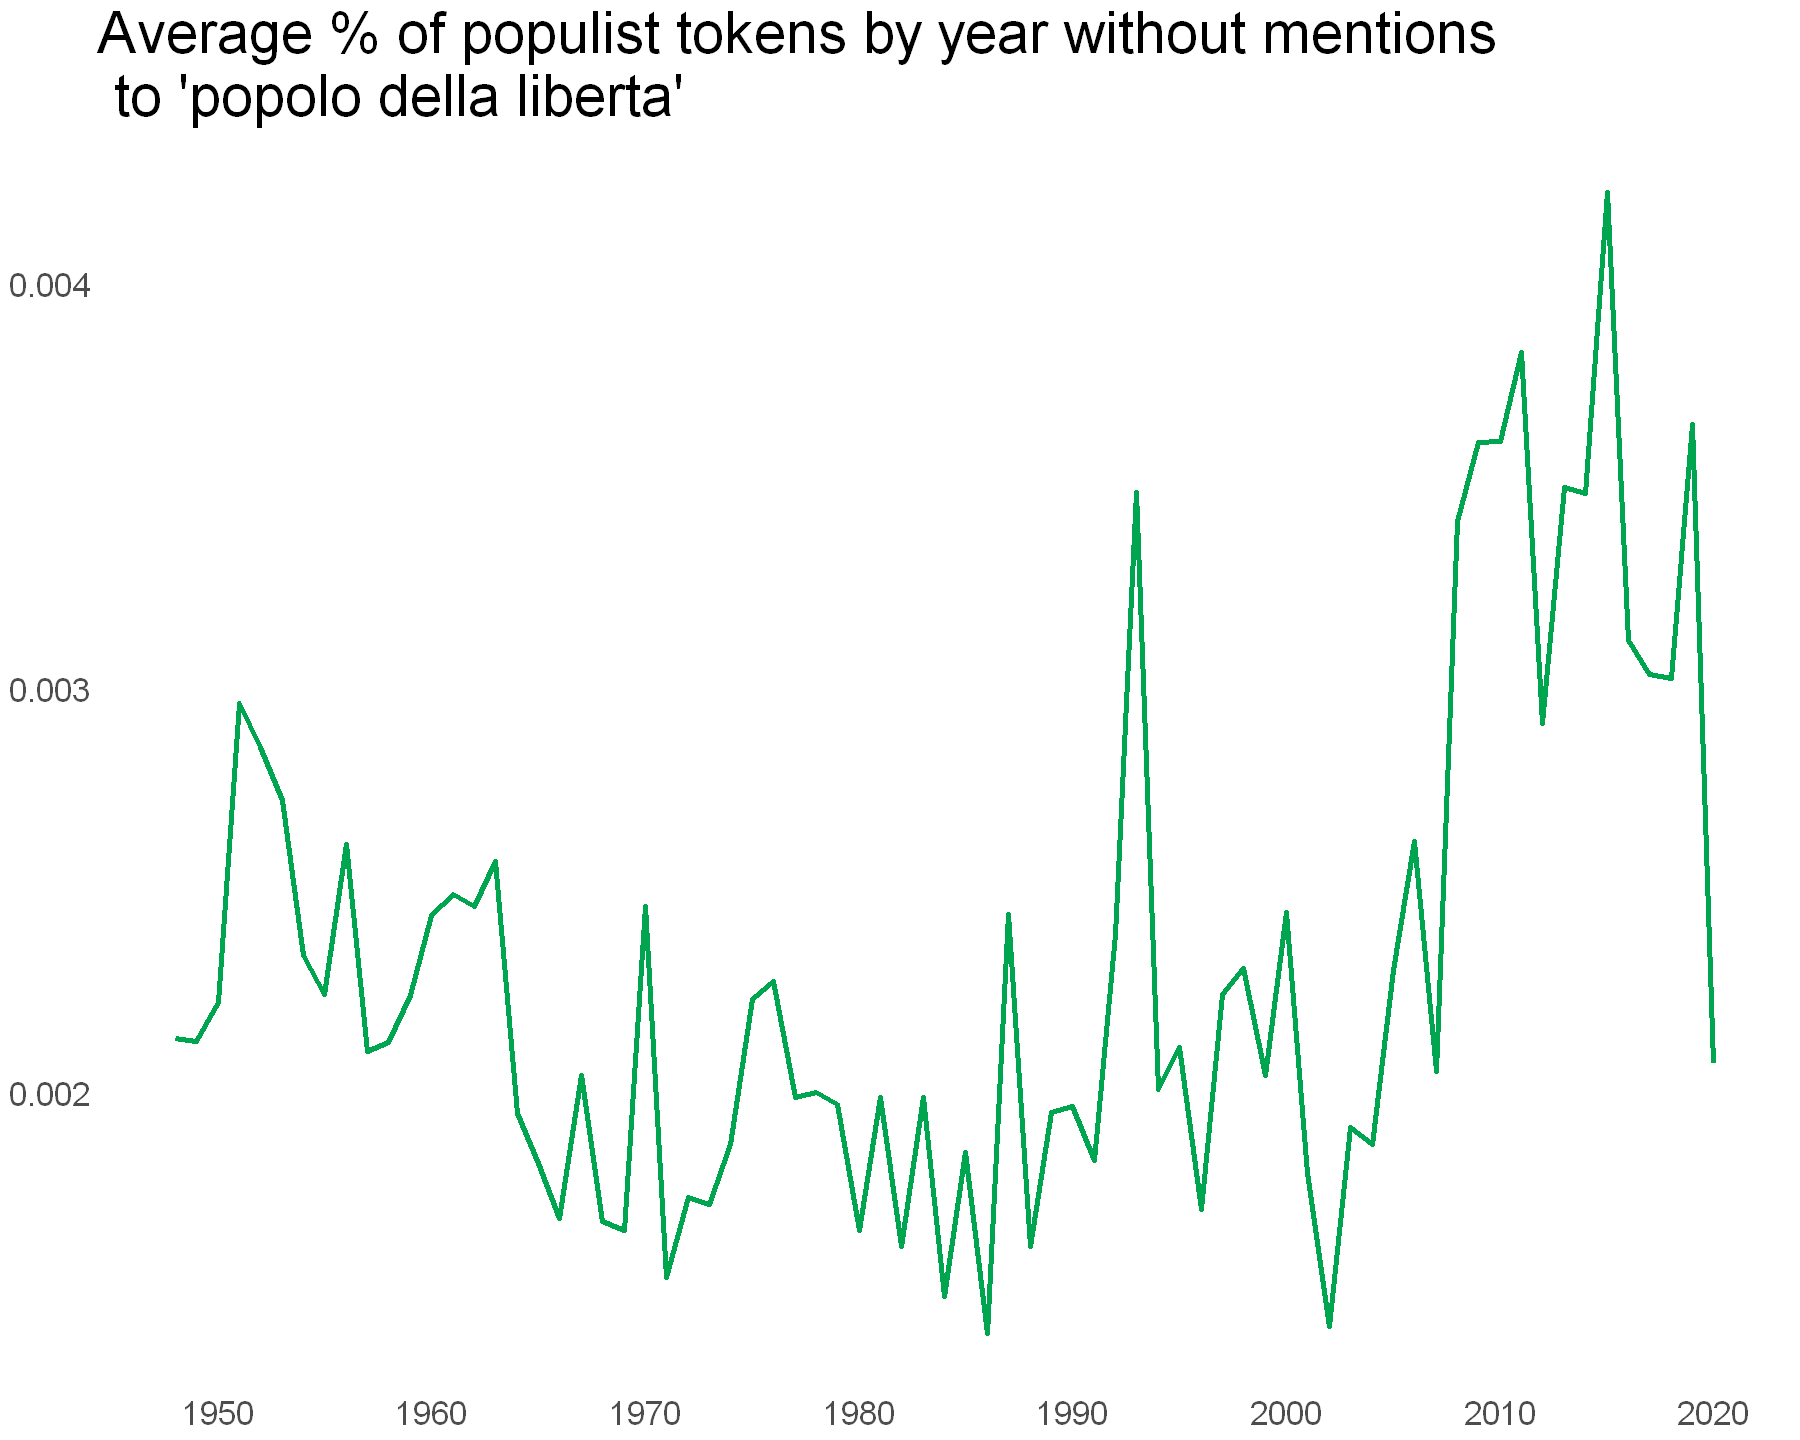

In [35]:
no_pdl %>% 
      group_by(year) %>% 
      summarise(avg_perc_of_populist_tokens = mean(perc_of_populist_toks, na.rm = TRUE)) %>% 
      ggplot(aes(x = year, y = avg_perc_of_populist_tokens)) +
      geom_line(colour = "#00A550", size = 1.5) +
      theme_classic() +
      scale_x_continuous(breaks = seq(from = 1950, to = 2020, by = 10)) +
      labs(title = "Average % of populist tokens by year without mentions\n to 'popolo della liberta'") +
      theme(line = element_blank(),
            axis.title = element_blank(),
            plot.title = element_text(size = 35),
            axis.text = element_text(size = 20))